In [1]:
import datetime as dt
import os
import sys
import sqlalchemy as sa
import pandas as pd

In [2]:
# Setup connection parameters
comp = os.environ["COMPUTERNAME"]  # Get the computer name from environment variables
dbase = "Financial_Securities"     # Define the name of the database

username = os.getlogin()
external_folder_path = 'C:/Users/' + username + '/Documents/Projects/Financial_Securities/Custom_Python_Functions'
sys.path.append(external_folder_path)
from custom_python_functions import create_connection, get_pricing_data, plot_pricing_candlestick, plot_pricing_line


# Create a connection to the database
s, e = create_connection(comp, dbase, "", "")
s1 = s()  # Instantiate a session object

In [3]:
# Define SQL query to retrieve tickers from the Yahoo_Equity_Prices table
sql_stat = """SELECT 
        TRIM(q2.Ticker) AS Ticker,
        q1.Date,
        ROUND(q1.[Open], 2) AS "Open",
        ROUND(q1.[High], 2) AS "High",
        ROUND(q1.[Low], 2) AS "Low",
        ROUND(q1.[Close], 2) AS "Close",
        q1.Volume AS "Volume"
FROM [Financial_Securities].[Equities].[Yahoo_Equity_Prices] q1
INNER JOIN [Financial_Securities].[Equities].[Equities] q2
ON q1.Ticker_ID = q2.Ticker_ID
ORDER BY q2.Ticker, q1.Date
"""

try:
    # Execute the SQL query and read the results into a DataFrame
    df_pricing = pd.read_sql(sql_stat, s1.bind)
    
except sa.exc.SQLAlchemyError as e:
    # Handle exceptions during SQL query execution
    print(f"Issue querying database tables! Error: {e}")
    s1.close()
    raise

In [4]:
df_pricing.head()

,Ticker,Date,Open,High,Low,Close,Volume
0,A,2021-01-04,118.94,120.09,117.11,115.98,2030700
1,A,2021-01-05,118.48,120.32,118.07,116.93,2344000
2,A,2021-01-06,118.69,123.88,118.21,120.14,2428500
3,A,2021-01-07,124.33,127.48,124.11,123.33,1775900
4,A,2021-01-08,126.49,127.64,125.85,124.21,1577200


In [5]:
df_pricing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465762 entries, 0 to 465761
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Ticker  465762 non-null  object 
 1   Date    465762 non-null  object 
 2   Open    465762 non-null  float64
 3   High    465762 non-null  float64
 4   Low     465762 non-null  float64
 5   Close   465762 non-null  float64
 6   Volume  465762 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 24.9+ MB


In [6]:
if df_pricing.empty:
    print("DataFrame is empty after SQL query.")
    
else:
    df_pricing['Date'] = pd.to_datetime(df_pricing['Date'])
    df_pricing['Year'] = df_pricing['Date'].dt.year
    df_pricing.sort_values(by=['Ticker', 'Date'], inplace=True)

    # Default Ticker used in single ticker analysis
    ticker = 'MSFT'

    df_pricing_yr = get_pricing_data(df_pricing, 'Year') 
    df_pricing_yr_ticker = df_pricing_yr[df_pricing_yr['Ticker'] == ticker].copy()
    df_pricing_yr_ticker.sort_values(by=['Date'], inplace=True)

    # Print yearly pricing data
    print(df_pricing_yr_ticker.to_string(index=False))
    
    plot_pricing_candlestick(df_pricing_yr_ticker, ticker, 'Year')

Ticker  Year       Date   Open   High    Low  Close   Volume
  MSFT  2021 2021-12-31 222.53 349.67 211.94 328.47 18000800
  MSFT  2022 2022-12-30 335.35 338.00 213.43 236.42 21938500
  MSFT  2023 2023-12-29 243.08 384.30 219.35 374.00 18723000
  MSFT  2024 2024-09-20 373.86 468.35 366.50 435.27 55167100


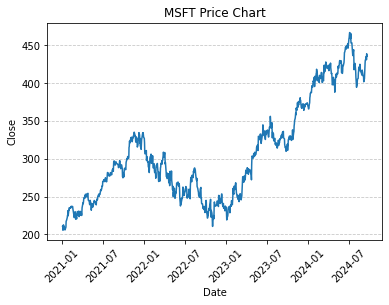

In [7]:
df_pricing_daily_ticker = df_pricing[df_pricing['Ticker'] == ticker].copy() 
plot_pricing_line(df_pricing_daily_ticker, ticker, 'Daily', 'Close')

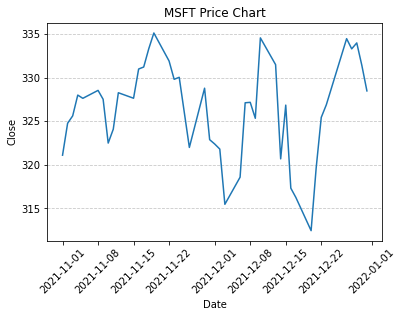

In [8]:
date_filter = (df_pricing_daily_ticker['Date'] >= '2021-11-01') & (df_pricing_daily_ticker['Date'] <= '2021-12-31')
df_pricing_daily_ticker = df_pricing_daily_ticker.loc[date_filter]
plot_pricing_line(df_pricing_daily_ticker, ticker, 'Daily', 'Close')
